## ライブラリの準備

In [ ]:
'''GoogleColaboratoryで実行する場合は以下のコマンドを実行
'''
# %pip install transformers==4.21.2 fugashi==1.1.2 ipadic==1.0.0

In [1]:
# データ加工に用いるライブラリ
import json
import unicodedata
import itertools
import re

# 出力整理に用いるライブラリ
import pandas as pd
from tqdm import tqdm
import random

# torch, BERT
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertJapaneseTokenizer, BertForTokenClassification

## データセットの準備

In [2]:
# データのダウンロード
!git clone --branch v2.0 https://github.com/stockmarkteam/ner-wikipedia-dataset

# データのロード
dataset = json.load(open('ner-wikipedia-dataset/ner.json', 'r'))

Cloning into 'ner-wikipedia-dataset'...
Note: switching to 'f7ed83626d90e5a79f1af99775e4b8c6cba15295'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [3]:
# 固有表現タイプの辞書
type_id_dictionary = {'人名': 1,
                      '法人名': 2,
                      '政治的組織名': 3,
                      'その他の組織名': 4,
                      '地名': 5,
                      '施設名': 6,
                      '製品名': 7,
                      'イベント名': 8}

'''idからtypeを取得する関数
'''
def get_type_from_id(id):
    keys = [key for key, value in type_id_dictionary.items() if value == id]
    if keys:
        return keys[0]
    return None

In [4]:
# 前処理
for data in dataset:
    # 正規化
    # ｱｲｳ → アイウ, ＡＢＣ → ABC, １２３ → 123
    data['text'] = unicodedata.normalize('NFKC', data['text'])

    # typeを対応するtype_idに変換
    for entity in data['entities']:
        entity['type_id'] = type_id_dictionary[entity['type']]
        del entity['type']

In [5]:
# データセットの分割
# 学習：検証：テスト = 6：2：2
size = len(dataset)
size_train_dataset = int(0.6 * size)
size_val_dataset = int(0.2 * size)

train_dataset = dataset[: size_train_dataset]
val_dataset = dataset[size_train_dataset : (size_train_dataset + size_val_dataset)]
test_dataset = dataset[size_train_dataset + size_val_dataset :]

# 学習・検証・テストデータのサイズを表示
print(f'学習データ数   : {len(train_dataset)}')
print(f'検証データ数   : {len(val_dataset)}')
print(f'テストデータ数 : {len(test_dataset)}')

学習データ数   : 3205
検証データ数   : 1068
テストデータ数 : 1070


## トークナイザの準備

In [6]:
'''固有表現抽出に適応したBertJapaneseTokenizerを拡張したトークナイザ
'''
class ExtensionTokenizer(BertJapaneseTokenizer):

    # 学習時に用いるラベル付きエンコーダ
    def tagged_encode_plus(self, data, max_length):
        text = data['text']         # dataから文字列を取得
        entities = data['entities'] # dataから固有表現を取得(出現順でソート)

        '''[Step1] 固有表現かそれ以外かで分割
        '''
        entities = sorted(entities, key=lambda x: x['span'][0]) # 固有表現の位置の昇順でソート

        data_splitted = [] # 分割後の文字列格納用
        head = 0           # 文字列の先頭のindex

        for entity in entities:
            # 次に出現する固有表現の先頭・末尾・IDを取得
            entity_head = entity['span'][0]
            entity_tail = entity['span'][1]
            label = entity['type_id']

            # 固有表現にID、固有表現以外に'0'をラベルとして付与
            data_splitted.append({'text': text[head:entity_head], 'label':0})
            data_splitted.append({'text': text[entity_head:entity_tail], 'label':label})

            head = entity_tail  # 先頭indexを更新

        # 最後の固有表現以降のtextに'0'をラベルとしてを付与
        data_splitted.append({'text': text[head:], 'label':0})

        # head = entity_startの時、{'text': '', 'label': 0}となってしまうため、textが空の要素を削除
        data_splitted = [ s for s in data_splitted if s['text'] ]

        '''[Step2] トークナイザを用い、分割された文字列をトークン化・ラベル付与
        '''
        tokens = []
        labels = []

        for s in data_splitted:
            text_splitted = s['text']
            label_splitted = s['label']

            tokens_splitted = self.tokenize(text_splitted)        # トークン化
            labels_splitted = [label_splitted] * len(tokens_splitted)  # 各トークンにラベル付与

            tokens.extend(tokens_splitted)  # トークンを結合
            labels.extend(labels_splitted)  # ラベルを結合

        '''[Step3] BERTに入力可能な形式に符号化
        '''
        encoding = self.encode_plus(tokens,
                                    max_length=max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_tensors='pt')

        # トークン[CLS]、[SEP]に'0'ラベルとして付与
        labels = [0] + labels[:max_length-2] + [0]
        # トークン[PAD]に'0'をラベルとして付与
        labels = labels + [0]*( max_length - len(labels) )

        encoding['labels'] = torch.tensor([labels])
        return encoding

    # テスト時に用いるencordingとspansを返すエンコーダ
    def untagged_encode_plus(self, text, max_length):
        '''[Step1] BERTに入力可能な形式に符号化
        '''
        encoding = self.encode_plus(text=text,
                                    max_length=max_length,
                                    padding='max_length',
                                    truncation=True,
                                    return_tensors = 'pt')

        '''[Step2]各トークンのスパンを格納
        '''
        spans = []

        tokens = self.convert_ids_to_tokens(encoding['input_ids'][0])
        head = 0

        for token in tokens:
            # '##'は文字数にカウントしないので読み飛ばす
            token = token.replace('##','')

            # スペシャルトークンの場合はダミーとしてspanを[-1, -1]とする
            if token == '[PAD]':
                spans.append([-1, -1])
            elif token == '[UNK]':
                spans.append([-1, -1])
            elif token == '[CLS]':
                spans.append([-1, -1])
            elif token == '[SEP]':
                spans.append([-1, -1])

            # text中からtokenをを探索し，開始位置 + 文字列長をspanとする
            # トークンが見つかるまでスペースを読み飛ばす
            else:
                length = len(token)
                while 1:
                    if token == text[head:head+length]:
                        spans.append([head, head+length])
                        head += length
                        break

                    head += 1

        return encoding, spans

In [7]:
# 日本語学習済みモデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

# トークナイザをロード
tokenizer = ExtensionTokenizer.from_pretrained(MODEL_NAME)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'ExtensionTokenizer'.


## データセット・データローダの作成

In [8]:
'''データローダに格納するデータセット
'''
class ExtensionDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        encoding = self.tokenizer.tagged_encode_plus(self.dataset[index], self.max_length)
        return encoding

In [9]:
# データセットの作成
dataset_train_for_loader = ExtensionDataset(dataset = train_dataset,
                                            tokenizer = tokenizer,
                                            max_length = 128)

dataset_val_for_loader = ExtensionDataset(dataset = val_dataset,
                                          tokenizer = tokenizer,
                                          max_length = 128)

# データローダの作成
dataloader_train = DataLoader(dataset_train_for_loader, batch_size=16, shuffle=True, pin_memory=True)
dataloader_val = DataLoader(dataset_val_for_loader, batch_size=256, shuffle=True, pin_memory=True)

dataloaders = {'train': dataloader_train, 'val': dataloader_val}

## 事前学習モデル

In [10]:
# 学習済みモデルをロード
model = BertForTokenClassification.from_pretrained(MODEL_NAME, num_labels=9)

print(f'\nmodelのパラメータを確認\n{model.get_parameter}')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the m


modelのパラメータを確認
<bound method Module.get_parameter of BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
    

### 予測

In [11]:
'''文字列の符号化、BERTによる推論、BERTの出力をentitiesに変換する関数
'''
def predict(text, tokenizer, max_length, model):
    # 符号化
    encoding, spans = tokenizer.untagged_encode_plus(text, max_length)

    # モデルとデータをGPUまたはCPUに乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    encoding = { key:value.to(device) for key, value in encoding.items() }

    # 予測
    with torch.no_grad():
        output = model(**encoding)

    # 最も高い確率のクラスを予測ラベルとする
    predicted_label = output.logits[0].argmax(-1).cpu().numpy().tolist()

    # スペシャルトークンを削除
    predicted_label = [label for label, span in zip(predicted_label, spans) if span[0] != -1]
    spans = [span for span in spans if span[0] != -1]

    # 同じラベルが連続するトークンをまとめる
    entities = []
    label_head = 0  # 連続するラベルの先頭
    for label, group in itertools.groupby(predicted_label):
        label_tail = label_head + len(list(group)) - 1 # 連続するラベルの末尾

        # 予測固有表現をentitiesに格納
        head = spans[label_head][0]
        tail = spans[label_tail][1]
        if label != 0:
            entity = {'name': text[head:tail],
                      'span': [head, tail],
                      'type_id': label}

            entities.append(entity)

        label_head = label_tail + 1

    return entities

In [12]:
entities_list = []            # 正解固有表現
predicted_entities_list = []  # 予測固有表現

for data in tqdm(test_dataset):
    entities_list.append(data['entities'])

    # 固有表現抽出
    predicted_entities = predict(data['text'], tokenizer, 128, model)
    predicted_entities_list.append(predicted_entities)

  0%|          | 0/1070 [00:00<?, ?it/s]

100%|██████████| 1070/1070 [42:55<00:00,  2.41s/it] 


In [36]:
# 結果をランダムに確認
for i in range(3):
    index = random.randint(0, len(test_dataset) - 1)

    print(f'text[{index:5}] : {test_dataset[index]["text"]}')
    print(f'正解固有表現 : {entities_list[index]}')
    print(f'予測固有表現 : {predicted_entities_list[index]}\n')

text[  499] : 翌年FC琉球に移籍するが、同年限りで引退。
正解固有表現 : [{'name': 'FC琉球', 'span': [2, 6], 'type_id': 4}]
予測固有表現 : [{'name': 'で', 'span': [17, 18], 'type_id': 5}]

text[  882] : 土家由岐雄は、日本の児童文学作家。
正解固有表現 : [{'name': '土家由岐雄', 'span': [0, 5], 'type_id': 1}, {'name': '日本', 'span': [7, 9], 'type_id': 5}]
予測固有表現 : [{'name': '、', 'span': [6, 7], 'type_id': 5}, {'name': '児童文学作家。', 'span': [10, 17], 'type_id': 5}]

text[  493] : 鴇田正憲は、兵庫県神戸市出身のサッカー選手、経営者。
正解固有表現 : [{'name': '鴇田正憲', 'span': [0, 4], 'type_id': 1}, {'name': '兵庫県神戸市', 'span': [6, 12], 'type_id': 5}]
予測固有表現 : [{'name': '兵庫', 'span': [6, 8], 'type_id': 5}, {'name': 'サッカー選手、経営者', 'span': [15, 25], 'type_id': 5}]



### 性能評価

In [37]:
'''適合率、再現率、F値を計算し、モデルを評価する関数
'''
def evaluate(dataset, entities_list, predicted_entities_list, type_id=None):
    entities_count = 0            # 正解固有表現の個数
    predicted_entities_count = 0  # 予測固有表現の個数
    correct_count = 0             # 予測固有表現うち正解の個数

    for entities, predicted_entities in zip(entities_list, predicted_entities_list):

        # 引数type_idが指定された場合、そのクラスの固有表現のみを抽出
        if type_id:
            entities = [ entity for entity in entities if entity['type_id'] == type_id ]
            predicted_entities = [ entity for entity in predicted_entities if entity['type_id'] == type_id ]

        # 重複固有表現をset型に変換
        get_span_type = lambda entity: (entity['span'][0], entity['span'][1], entity['type_id'])
        set_entities = set( get_span_type(entity) for entity in entities )
        set_entities_predicted = set( get_span_type(entity) for entity in predicted_entities )

        # 各個数を更新
        entities_count += len(entities)
        predicted_entities_count += len(predicted_entities)
        correct_count += len( set_entities & set_entities_predicted )

    precision = correct_count / predicted_entities_count    # 適合率
    recall = correct_count / entities_count                 # 再現率
    if(precision + recall != 0):
        f_value = 2 * precision*recall / (precision + recall) # F値
    else:
        f_value = -1

    result = {'entities_count': entities_count,
              'predicted_entities_count': predicted_entities_count,
              'correct_count': correct_count,
              'precision': precision,
              'recall': recall,
              'f_value': f_value}

    return result

In [38]:
evaluation_df = pd.DataFrame()

# 各クラスの予測性能を評価
for key, value in type_id_dictionary.items():
    evaluation = evaluate(test_dataset, entities_list, predicted_entities_list, type_id=value)
    evaluation_df[key] = evaluation.values()  # 各列に評価結果を格納

# 全クラスの予測性能を評価
evaluation_all = evaluate(test_dataset, entities_list, predicted_entities_list, type_id=None)
evaluation_df['ALL'] = evaluation_all.values()  #　全クラスの結果を末尾の列に格納

# 行名を設定
evaluation_df.index = evaluation_all.keys()

evaluation_df

,人名,法人名,政治的組織名,その他の組織名,地名,施設名,製品名,イベント名,ALL
entities_count,604.0,504.0,249.000000,222.0,452.000000,222.0,231.0,203.000000,2687.000000
predicted_entities_count,60.0,244.0,2005.000000,1420.0,3634.000000,244.0,177.0,1245.000000,9029.000000
correct_count,0.0,0.0,2.000000,0.0,19.000000,0.0,0.0,1.000000,22.000000
precision,0.0,0.0,0.000998,0.0,0.005228,0.0,0.0,0.000803,0.002437
recall,0.0,0.0,0.008032,0.0,0.042035,0.0,0.0,0.004926,0.008188
f_value,-1.0,-1.0,0.001775,-1.0,0.009300,-1.0,-1.0,0.001381,0.003756


## ファインチューニング

### 学習

In [39]:
'''モデルをファインチューニングする関数
'''
def train(model, dataloaders, optimizer, max_epoch):

    # モデルをGPUまたはCPUに乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    print(f'使用デバイス：{device}')

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    train_average_loss_list = []
    val_average_loss_list = []
    history = {}

    # epochのループ
    for epoch in range(max_epoch):
        print(f'\nepoch [{epoch+1}/{max_epoch}]')

        '''[Step1]学習
        '''
        model.train()

        iteration = 1
        sum_loss = 0.0

        # ミニバッチを取り出す
        for batch in tqdm(dataloaders['train']):
            input_ids = batch['input_ids'][0].to(device)
            attention_mask = batch['attention_mask'][0].to(device)
            labels = batch['labels'][0].to(device)

            optimizer.zero_grad() # optimizerを初期化

            loss, logits = model(input_ids = input_ids,
                                 token_type_ids = None,
                                 attention_mask = attention_mask,
                                 labels = labels,
                                 return_dict = False)

            loss.backward() # 順伝搬
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 勾配クリッピング
            optimizer.step()  # 最適化

            # 1エポックの損失の和を更新
            sum_loss += loss.item() * dataloaders['train'].batch_size

            iteration += 1

        # 1エポックの平均損失を記録
        average_loss = sum_loss / len(dataloaders['train'].dataset)
        train_average_loss_list.append(average_loss)

        '''[Step2]検証
        '''
        model.eval()

        iteration = 1
        sum_loss = 0.0
        val_accuracy = 0.0

        # ミニバッチを取り出す
        for batch in (dataloaders['val']):
            input_ids = batch['input_ids'][0].to(device)
            attention_mask = batch['attention_mask'][0].to(device)
            labels = batch['labels'][0].to(device)

            optimizer.zero_grad() # optimizerを初期化

            loss, logits = model(input_ids = input_ids,
                                 token_type_ids = None,
                                 attention_mask = attention_mask,
                                 labels = labels,
                                 return_dict = False)

            # 1エポックの損失の和を更新
            sum_loss += loss.item() * dataloaders['val'].batch_size

            iteration += 1

        # 1エポックの平均損失を記録
        average_loss = sum_loss / len(dataloaders['val'].dataset)
        val_average_loss_list.append(average_loss)

        print(f'train_loss: {train_average_loss_list[epoch]:.4f}, val_loss: {val_average_loss_list[epoch]:.4f}')

    history['train_loss'] = train_average_loss_list
    history['val_loss'] = val_average_loss_list

    return model,history

In [40]:
max_epoch = 5   # エポック数
lr = 2e-5       # 学習率

# 最適化器としてAdamを使用
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

# ファインチューニング
trained_model, history = train(model = model,
                               dataloaders = dataloaders,
                               optimizer = optimizer,
                               max_epoch=max_epoch)

使用デバイス：cpu

epoch [1/5]


100%|██████████| 201/201 [36:48<00:00, 10.99s/it] 


train_loss: 0.2147, val_loss: 0.1705

epoch [2/5]


100%|██████████| 201/201 [15:34<00:00,  4.65s/it]


train_loss: 0.0574, val_loss: 0.0575

epoch [3/5]


100%|██████████| 201/201 [15:45<00:00,  4.70s/it]


train_loss: 0.0511, val_loss: 0.0881

epoch [4/5]


100%|██████████| 201/201 [15:22<00:00,  4.59s/it]


train_loss: 0.0369, val_loss: 0.0110

epoch [5/5]


100%|██████████| 201/201 [15:57<00:00,  4.76s/it]


train_loss: 0.0425, val_loss: 0.0009


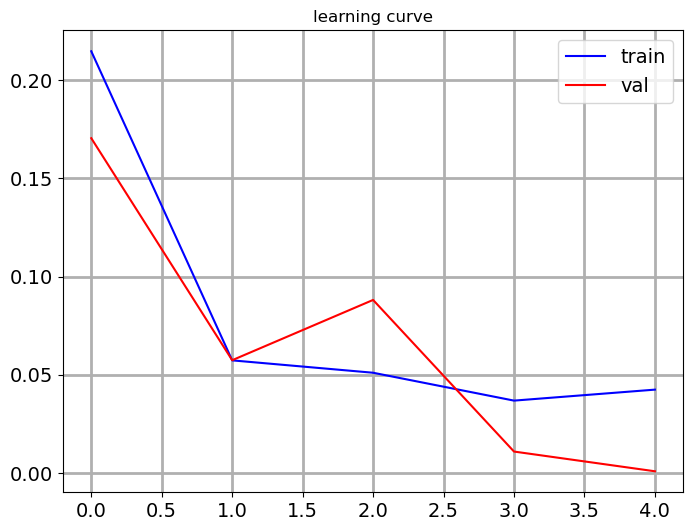

In [41]:
# 学習曲線の表示
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(history['train_loss'],label='train', c='b')
plt.plot(history['val_loss'],label='val', c='r')
plt.title('learning curve')
plt.xticks(size=14)
plt.yticks(size=14)
plt.grid(lw=2)
plt.legend(fontsize=14)
plt.show()

### 予測

In [42]:
trained_entities_list = []           # 正解固有表現
trained_predicted_entities_list = [] # 予測固有表現

for data in tqdm(test_dataset):
    trained_entities_list.append(data['entities'])

    # 固有表現抽出
    predicted_entities = predict(data['text'], tokenizer, 128, trained_model)
    trained_predicted_entities_list.append(predicted_entities)

100%|██████████| 1070/1070 [12:55<00:00,  1.38it/s]


In [47]:
# 結果をランダムに確認
for i in range(3):
    index = random.randint(0, len(test_dataset) - 1)

    print(f'text[{index:5}] : {test_dataset[index]["text"]}')
    print(f'正解固有表現 : {trained_entities_list[index]}')
    print(f'予測固有表現 : {trained_predicted_entities_list[index]}\n')

text[  938] : 1988年、テイチクに移籍し、シングル「役者」を発売、約10年ぶりに本格的な歌手活動を再開し、テレビの歌番組に出演するなど精力的な活動を行う。
正解固有表現 : [{'name': 'テイチク', 'span': [6, 10], 'type_id': 2}, {'name': '役者', 'span': [20, 22], 'type_id': 7}]
予測固有表現 : [{'name': 'テイチク', 'span': [6, 10], 'type_id': 2}, {'name': '役者', 'span': [20, 22], 'type_id': 7}]

text[  886] : 親会社京成電鉄の経営悪化等により徐々に店舗を売却または閉鎖し、現在は茨城県内の3店舗のみ営業している。
正解固有表現 : [{'name': '京成電鉄', 'span': [3, 7], 'type_id': 2}, {'name': '茨城', 'span': [34, 36], 'type_id': 5}]
予測固有表現 : [{'name': '京成電鉄', 'span': [3, 7], 'type_id': 2}, {'name': '茨城県内', 'span': [34, 38], 'type_id': 5}]

text[  953] : ラフーン家は主に農家だったが、政治の世界にも多少の経験があった。
正解固有表現 : [{'name': 'ラフーン', 'span': [0, 4], 'type_id': 1}]
予測固有表現 : [{'name': 'ラフーン', 'span': [0, 4], 'type_id': 1}]



### 性能評価

In [45]:
evaluation_df = pd.DataFrame()

# 各クラスの予測性能を評価
for key, value in type_id_dictionary.items():
    evaluation = evaluate(test_dataset, trained_entities_list, trained_predicted_entities_list, type_id=value)
    evaluation_df[key] = evaluation.values()  # 各列に評価結果を格納

# 全クラスの予測性能を評価
evaluation_all = evaluate(test_dataset, trained_entities_list, trained_predicted_entities_list, type_id=None)
evaluation_df['ALL'] = evaluation_all.values()  # 全クラスの結果を末尾の列に格納

# 行名を設定
evaluation_df.index = evaluation_all.keys()

evaluation_df

,人名,法人名,政治的組織名,その他の組織名,地名,施設名,製品名,イベント名,ALL
entities_count,604.000000,504.000000,249.000000,222.000000,452.000000,222.000000,231.000000,203.000000,2687.000000
predicted_entities_count,608.000000,472.000000,239.000000,228.000000,485.000000,259.000000,226.000000,210.000000,2727.000000
correct_count,553.000000,412.000000,164.000000,177.000000,391.000000,170.000000,156.000000,170.000000,2193.000000
precision,0.909539,0.872881,0.686192,0.776316,0.806186,0.656371,0.690265,0.809524,0.804180
recall,0.915563,0.817460,0.658635,0.797297,0.865044,0.765766,0.675325,0.837438,0.816152
f_value,0.912541,0.844262,0.672131,0.786667,0.834578,0.706861,0.682713,0.823245,0.810122


## 銀河鉄道の夜の固有表現抽出

In [ ]:
'''GoogleColaboratoryで実行する場合はドライブをマウントしてtxtファイルを参照
'''
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# %cd /content/gdrive/MyDrive/…

In [48]:
with open('gingatetsudono_yoru.txt', mode='r') as f:
    text = f.read()

print(text)

銀河鉄道の夜
宮沢賢治

-------------------------------------------------------
【テキスト中に現れる記号について】

《》：ルビ
（例）云《い》われたり

｜：ルビの付く文字列の始まりを特定する記号
（例）光る粒｜即《すなわ》ち

［＃］：入力者注　主に外字の説明や、傍点の位置の指定
　　　（数字は、JIS X 0213の面区点番号、または底本のページと行数）
（例）※［＃小書き平仮名ん、168-12］
-------------------------------------------------------

［＃３字下げ］一、午后《ごご》の授業［＃「一、午后の授業」は中見出し］

「ではみなさんは、そういうふうに川だと云《い》われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊《つる》した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指《さ》しながら、みんなに問《とい》をかけました。
　カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。
　ところが先生は早くもそれを見附《みつ》けたのでした。
「ジョバンニさん。あなたはわかっているのでしょう。」
　ジョバンニは勢《いきおい》よく立ちあがりましたが、立って見るともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた云いました。
「大きな望遠鏡で銀河をよっく調べると銀河は大体何でしょう。」
　やっぱり星だとジョバンニは思いましたがこんどもすぐに答えることができませんでした。
　先生はしばらく困ったようすでしたが、眼《め》をカムパネルラの方へ向けて、
「ではカムパネルラさん。」と名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上ったままやはり答えができま

In [49]:
#前処理
# ヘッダとフッタの削除
text = re.split(r'\-{5,}',text)[2]
text = re.split(r'底本：', text)[0]
text = text.strip() # 連続する改行文字の削除

text = re.sub(r'《.+?》', '', text)     # ルビを削除
text =text.replace('｜', '')            # ルビの付を削除
text = re.sub(r'［＃.+?］', '', text)   # 入力者注を削除

text = unicodedata.normalize('NFKC', text)

print(text)

一、午后の授業

「ではみなさんは、そういうふうに川だと云われたり、乳の流れたあとだと云われたりしていたこのぼんやりと白いものがほんとうは何かご承知ですか。」先生は、黒板に吊した大きな黒い星座の図の、上から下へ白くけぶった銀河帯のようなところを指しながら、みんなに問をかけました。
 カムパネルラが手をあげました。それから四五人手をあげました。ジョバンニも手をあげようとして、急いでそのままやめました。たしかにあれがみんな星だと、いつか雑誌で読んだのでしたが、このごろはジョバンニはまるで毎日教室でもねむく、本を読むひまも読む本もないので、なんだかどんなこともよくわからないという気持ちがするのでした。
 ところが先生は早くもそれを見附けたのでした。
「ジョバンニさん。あなたはわかっているのでしょう。」
 ジョバンニは勢よく立ちあがりましたが、立って見るともうはっきりとそれを答えることができないのでした。ザネリが前の席からふりかえって、ジョバンニを見てくすっとわらいました。ジョバンニはもうどぎまぎしてまっ赤になってしまいました。先生がまた云いました。
「大きな望遠鏡で銀河をよっく調べると銀河は大体何でしょう。」
 やっぱり星だとジョバンニは思いましたがこんどもすぐに答えることができませんでした。
 先生はしばらく困ったようすでしたが、眼をカムパネルラの方へ向けて、
「ではカムパネルラさん。」と名指しました。するとあんなに元気に手をあげたカムパネルラが、やはりもじもじ立ち上ったままやはり答えができませんでした。
 先生は意外なようにしばらくじっとカムパネルラを見ていましたが、急いで「では。よし。」と云いながら、自分で星図を指しました。
「このぼんやりと白い銀河を大きないい望遠鏡で見ますと、もうたくさんの小さな星に見えるのです。ジョバンニさんそうでしょう。」
 ジョバンニはまっ赤になってうなずきました。けれどもいつかジョバンニの眼のなかには涙がいっぱいになりました。そうだ僕は知っていたのだ、勿論カムパネルラも知っている、それはいつかカムパネルラのお父さんの博士のうちでカムパネルラといっしょに読んだ雑誌のなかにあったのだ。それどこでなくカムパネルラは、その雑誌を読むと、すぐお父さんの書斎から巨きな本をもってきて、ぎんがというところをひろげ、まっ黒な頁いっぱいに白い点々のある美しい

In [50]:
novel_predicted_entities_list = [] # 予測固有表現

# テキストを1行ずつ取り出し
lines = text.split("\n")
for line in tqdm(lines):
    predicted_entities = predict(line, tokenizer, 128, trained_model)
    novel_predicted_entities_list.extend(predicted_entities)

100%|██████████| 479/479 [02:22<00:00,  3.35it/s]


In [51]:
# idごとに振り分け
novel_predicted_entities_map = {'人名': [],
                                '法人名': [],
                                '政治的組織名': [],
                                'その他の組織名': [],
                                '地名': [],
                                '施設名':[],
                                '製品名':[],
                                'イベント名':[]}

for entity in novel_predicted_entities_list:
    if entity['type_id'] == 1:
        novel_predicted_entities_map['人名'].append(entity['name'])
    elif entity['type_id'] == 2:
        novel_predicted_entities_map['法人名'].append(entity['name'])
    elif entity['type_id'] == 3:
        novel_predicted_entities_map['政治的組織名'].append(entity['name'])
    elif entity['type_id'] == 4:
        novel_predicted_entities_map['その他の組織名'].append(entity['name'])
    elif entity['type_id'] == 5:
        novel_predicted_entities_map['地名'].append(entity['name'])
    elif entity['type_id'] == 6:
        novel_predicted_entities_map['施設名'].append(entity['name'])
    elif entity['type_id'] == 7:
        novel_predicted_entities_map['製品名'].append(entity['name'])
    elif entity['type_id'] == 8:
        novel_predicted_entities_map['イベント名'].append(entity['name'])

In [52]:
# 重複要素削除して抽出結果を表示
for key, value in type_id_dictionary.items():
    novel_predicted_entities_map[key] = set(novel_predicted_entities_map[key])
    print(f'\n[{key}]')
    for entity in novel_predicted_entities_map[key]:
        print(entity)


[人名]
きくよ
ジョバンニ
ザウエル
虫めがね
コムパス
あすこ
カトウ
カムパネル
かおる子
なんべん
向う
鷺
ひる
孔雀
燈
マルソ
サウ
かお
鶴や雁
インデアン
ザネリ
のり
ジョバン
鳥捕り
お宮
大学士
わっし
鶴
かおる
さぎも白鳥
カムパネルラ

[法人名]
銀河鉄道
牛乳

[政治的組織名]
空
工兵大隊

[その他の組織名]
新世界交響楽

[地名]
白鳥の島
南十字
北
うし
森
ケンタウル
あすこ
カムパネル
天の川
コンネクテカット州
ザンクロス
白鳥区
本国
コロラド
バルドラ
方
サウザンクロス
ランカシャイヤ
アルビレオ

[施設名]
白鳥停車場
青い橄欖の
六、銀河ステーション
プリオシン海岸
白鳥
ひる学校
銀河ステーション
北十字

[製品名]
露
大熊
あなたの神さまうその神さまよ。
いいえ。
ごとごとごとごと汽車
いま海へ行ってらあ。
ハルレヤハルレヤ。
さよなら
の停車場
いいえ
烏
どら、
ええ河
鷺
ケンタウル露
神さまうその神さまだい。
ケンタウルス
ねえ
ああ。
ハルレヤ、ハルレヤ
ぼくたべよう。
せ
僕わからない
そうそう
降りよう。
雀
ザネリ
ま
はなしてごらん
わっし
さよなら。
だい
鳥です
あ孔雀
カムパネルラ

[イベント名]
こんや
星祭
ケンタウル祭
銀河の
